In [26]:
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pathlib
from PIL import Image


In [27]:
class augmented_dataset(Dataset):
    def __init__(self, targ_dir):
        self.paths = list(pathlib.Path(targ_dir).glob("*.jpg"))
        self.classes = ['Correct']
        self.class_to_idx = {'Classes':0}
        self.data = [(img, 'augm1') for img in self.paths]
        self.data.extend([(img, 'augm2') for img in self.paths])
        self.data.extend([(img, 'augm3') for img in self.paths])
        self.transform1 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.ColorJitter(1),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        ])
        self.transform2 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        ])
        self.transform3 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomErasing(1),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        if self.data[i][1] == 'augm1':
            img = Image.open(self.data[i][0])
            img = self.transform1(img)

        if self.data[i][1] == 'augm2':
            img = Image.open(self.data[i][0])
            img = self.transform2(img)

        if self.data[i][1] == 'augm3':
            img = Image.open(self.data[i][0])
            img = self.transform3(img)              

        return img,0

#train and test data directory
data_dir = "PetImages/Training"
correct_label_dir = "PetImages/Training/Correct"

dataset = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]))

test = augmented_dataset(correct_label_dir)
print("OOga",len(test))
item1, lab1 = test[0]
print(item1)

# print("Classes", (dataset.class_to_idx), (dataset.classes))
print(len(dataset))
t1, l1 = dataset[0]
print(t1)

concat_dataset = ConcatDataset([dataset, test])
print(len(concat_dataset))

#Processing code
testn = len(concat_dataset)
testn_train = 10000
train1, test1 = random_split(concat_dataset, [testn_train, testn-testn_train])
print(len(train1))

n = len(train1)
n_train = int(0.7 * n)
train, test = random_split(train1, [n_train, n-n_train])


#Loading training and testing set into batches
train_dl = DataLoader(train, batch_size=500, num_workers=0, shuffle=True)
test_dl = DataLoader(test, batch_size=100, num_workers=0, shuffle=False)



OOga 25554
tensor([[[0.1555, 0.1582, 0.1635,  ..., 0.3620, 0.3593, 0.3566],
         [0.1555, 0.1582, 0.1635,  ..., 0.3593, 0.3566, 0.3566],
         [0.1528, 0.1555, 0.1609,  ..., 0.3566, 0.3539, 0.3512],
         ...,
         [0.1180, 0.1153, 0.1099,  ..., 0.2172, 0.2252, 0.2279],
         [0.0912, 0.0885, 0.0885,  ..., 0.2252, 0.2333, 0.2359],
         [0.0804, 0.0804, 0.0804,  ..., 0.2279, 0.2359, 0.2386]],

        [[0.1501, 0.1528, 0.1582,  ..., 0.3593, 0.3566, 0.3539],
         [0.1501, 0.1528, 0.1582,  ..., 0.3566, 0.3566, 0.3539],
         [0.1475, 0.1501, 0.1555,  ..., 0.3539, 0.3512, 0.3512],
         ...,
         [0.1019, 0.0992, 0.0938,  ..., 0.0804, 0.0885, 0.0912],
         [0.0751, 0.0724, 0.0724,  ..., 0.0885, 0.0965, 0.0992],
         [0.0643, 0.0643, 0.0643,  ..., 0.0912, 0.0992, 0.1019]],

        [[0.1796, 0.1823, 0.1877,  ..., 0.3968, 0.3941, 0.3914],
         [0.1796, 0.1823, 0.1877,  ..., 0.3941, 0.3914, 0.3888],
         [0.1770, 0.1796, 0.1850,  ..., 0.3888,

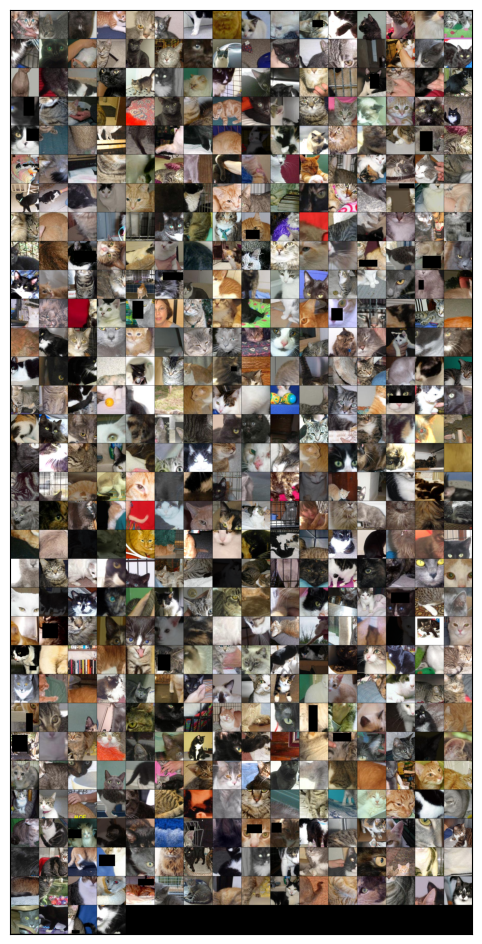

In [24]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [28]:
class CNN(nn.Module):
    #https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.drop = nn.Dropout2d(p=0.2)   

        self.fc = nn.Linear(in_features=24 * 64 * 64, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))

        x = F.relu(self.pool(self.conv2(x)))

        x = F.dropout(self.drop(x), training=self.training)

        x = x.view(-1, 24 * 64 * 64)

        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"

model = CNN(num_classes=2).to(device)
print(model)

def train(model, device, train_loader, optimizer, epoch):
    # Set the model to train
    model.train()
    train_loss = 0
    print("Epoch: ", epoch)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("\tTraining batch {} Loss: {:.6f}".format(batch_idx + 1, loss.item()))

    avg_loss = train_loss / (batch_idx+1)
    print("Training set: Average loss: {:.6f}".format(avg_loss))
    return avg_loss


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += loss_criteria(output, target).item()

            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target == predicted).item()

    
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f})\n'.format(avg_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return avg_loss


optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 10
print("Training on", device)
for epoch in range (1, epochs + 1):
    train_loss = train(model, device, train_dl, optimizer, epoch)
    test_loss = test(model, device, test_dl)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    

CNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=98304, out_features=2, bias=True)
)
Training on cuda
Epoch:  1
	Training batch 1 Loss: 0.638112
	Training batch 2 Loss: 78.970428
	Training batch 3 Loss: 16.975424
	Training batch 4 Loss: 2.895538
	Training batch 5 Loss: 0.628893
	Training batch 6 Loss: 0.691705
	Training batch 7 Loss: 0.675015
	Training batch 8 Loss: 0.651368
	Training batch 9 Loss: 0.628059
	Training batch 10 Loss: 0.581467
	Training batch 11 Loss: 0.575071
	Training batch 12 Loss: 0.578313
	Training batch 13 Loss: 0.544276
	Training batch 14 Loss: 0.581926
Training set: Average loss: 7.543971
Validation set: Average loss: 0.532917, Accuracy: 2323/3000 (77)

Epoch:  2
	Training batch 1 Loss: 0.558827
	Training 

Getting predictions from test set…


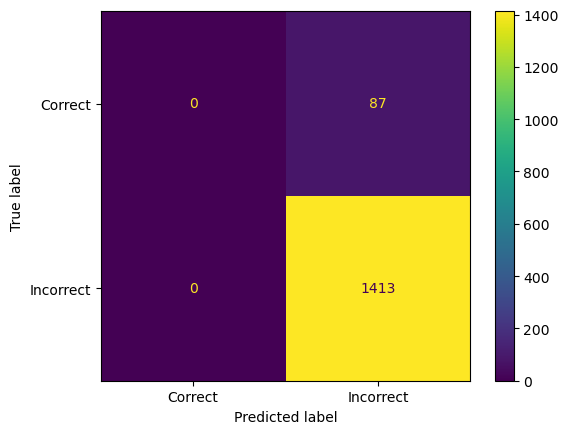

In [21]:
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set…")
for data, target in test_dl:
    data = data.to(device)
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data):
        predictions.append(torch.argmax(prediction).item())

# Plot the confusion matrix
labels = ["Correct", "Incorrect"]
cm = confusion_matrix(truelabels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()